In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gensim as gs
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')
import fasttext

In [2]:
train_dataset = pd.read_csv('../train_data/final_train_dataset', delimiter=',')
validation_dataset = pd.read_csv('../train_data/final_validation_dataset', delimiter=',')

In [3]:
embedding_model = gs.models.FastText.load('../train_embedding_models/fasttext_embedding_50d_all_signals')

In [4]:
MAX_PAD = 31

def sequence_padding(X_DIM, value):
    
    value_padding = np.pad(value, ((0,MAX_PAD - X_DIM),(0,0)), 'constant')
    
    return value_padding

In [5]:
def create_embedding(value):

    value = tknzr.tokenize(str(value))
    
    if len(value) < MAX_PAD:
        
        embedding = embedding_model.wv[value]
        
        padding_embedding = sequence_padding(embedding.shape[0],embedding)
        
        return padding_embedding
        
    else:
        
        embedding = embedding_model.wv[value[0:MAX_PAD]]
        
        return embedding

In [6]:
train_article_title = []
train_table_title = []
train_label = []

for i,row in tqdm(train_dataset.iterrows()):
    
    train_article_title.append(create_embedding(row['article_page_title']))
    train_table_title.append(create_embedding(row['table_page_title']))
    train_label.append(row['label'])

169500it [00:53, 3192.71it/s]


In [7]:
train_article_title = np.array(train_article_title)
train_table_title = np.array(train_table_title)
train_label = np.array(train_label)

In [8]:
train_article_title.shape

(169500, 31, 50)

In [9]:
validation_article_title = []
validation_table_title = []
validation_label = []

for i, row in tqdm(validation_dataset.iterrows()):
    
    validation_article_title.append(create_embedding(row['article_page_title']))
    validation_table_title.append(create_embedding(row['table_page_title']))  
    validation_label.append(row['label'])

18834it [00:05, 3215.43it/s]


In [10]:
validation_article_title = np.array(validation_article_title)
validation_table_title = np.array(validation_table_title)
validation_label = np.array(validation_label)

In [11]:
validation_article_title.shape

(18834, 31, 50)

In [12]:
def affinity_method(query, document):
    
    transpose_document = tf.transpose(document,perm=[0, 2, 1])
    
    affinity = tf.matmul(query,transpose_document)
    
    normalize_affinity = tf.nn.softmax(affinity)
    
    return normalize_affinity

In [13]:
def attention_model():
    
    article_title = tf.keras.Input(shape=(31,50), dtype='float32')
    table_title = tf.keras.Input(shape=(31,50), dtype='float32')
    
    affinity_titleA_titleB = affinity_method(article_title,table_title)
    
    learned_vector = tf.keras.layers.Flatten()(affinity_titleA_titleB)
   
    MLP_input = tf.keras.layers.Dense(64, activation='relu')(learned_vector)
    dropout1 = tf.keras.layers.Dropout(0.5, name="dropout1")(MLP_input)
    MLP_hidden = tf.keras.layers.Dense(32, activation='relu')(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.5, name="dropout2")(MLP_hidden)
    MLP_output = tf.keras.layers.Dense(1,activation='sigmoid')(dropout2)
    
    model = tf.keras.Model(inputs=[article_title,table_title],outputs=MLP_output)
    
    return model

In [14]:
model = attention_model()

In [15]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=['accuracy'])

In [16]:
filepath="affinity_model_title_{epoch:02d}_{val_accuracy:.4f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
history = model.fit([train_article_title, train_table_title], train_label, 
          epochs=20, 
          batch_size=32, 
          validation_data=([validation_article_title, validation_table_title], validation_label),
          callbacks=callbacks_list)

Train on 169500 samples, validate on 18834 samples
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
169056/169500 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8190
Epoch 00001: val_accuracy improved from -inf to 0.85569, saving model to affinity_model_title_01_0.8557.h5
169500/169500 [==============================] - 7s 42us/sample - loss: 0.4339 - accuracy: 0.8192 - val_loss: 0.3613 - val_accuracy: 0.8557
Epoch 2/20
168992/169500 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.8398
Epoch 00002: val_accuracy improved from 0.85569 to 0.86073, saving model to affinity_model_title_02_0.8607.h5
169500/169500 [==============================] - 7s 39us/sample - loss: 0.3986 - accuracy: 0.8398 - val_loss: 0.3466 - val_accuracy: 0.8607
Epoch 3/20
168800/169500 [============================>.] - ETA: 0s - loss: 0.3897 - accuracy: 0.8434
Epoch 00003: val_accuracy improved from 0.86073 to 0

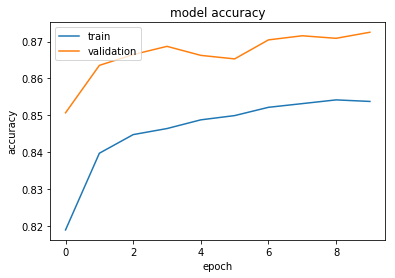

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

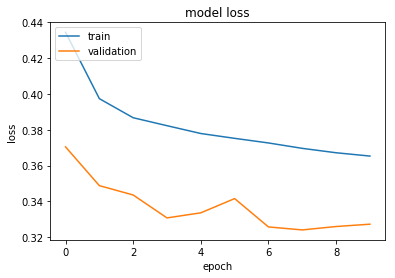

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
model = tf.keras.models.load_model('affinity_plus_attention_model_title_02_0.9380.h5')

In [31]:
y_prob = model.predict([validation_article_title,validation_table_title])
y_predict = (y_prob > 0.5).astype(np.int)
accuracy_score(validation_label, y_predict)

0.937984496124031

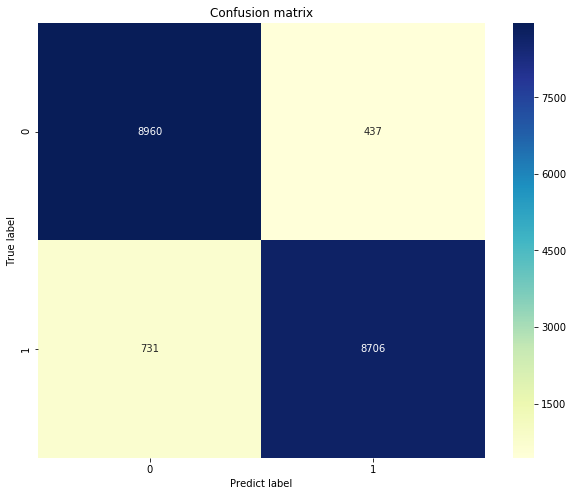

In [32]:
import seaborn as sns
import sklearn.metrics
confusion_matrix = sklearn.metrics.confusion_matrix(validation_label, y_predict)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu")#, annot_kws={"size": 15});
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predict label')
plt.show()